# Face Detection Project by Sarvesh Chandra

In [0]:
# Note:
# Python3 is used.

# Table of Content:
#1. Import all the necessary libraries.
#2. Mount Google Drive.
#3. Change directory with os.chdir().
#4. Load the data file.
#5. Check the shape of the data received.
#6. Check one sample from the data.
#7. Reshape the image dimensions to 224x224.
#8. Create the features and labels.
#9. Print a sample image and image array from the features and labels.
#10. Create the model with MobileNet as the model and use Unet architecture layers.
#11. Call the model function.
#12. Create definitions for dice coefficient and loss.
#13. Compile the model with Adam optimizer.
#14. Define checkpoint and early stopping.
#15. Fit the model.
#16. Load the weights file saved by ModelCheckpoint and get a predicted mask for a sample image.
#17. Impose the mask on the image and display.

In [0]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

### Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.chdir("/content/drive")

##### Load the data file "images.npy"

In [0]:
data = np.load("/content/drive/My Drive/PGPAIML/CV/Face Detection Project/images.npy", allow_pickle = True)

##### Check the shape

In [6]:
data.shape

(409, 2)

##### Check one sample

In [0]:
a = data[0,0]

In [8]:
a.shape

(333, 650, 3)

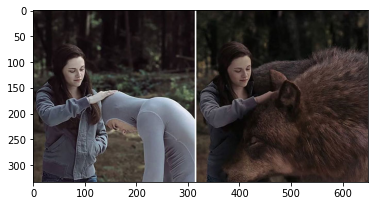

In [9]:
plt.imshow(a)
plt.show()

In [10]:
data[0,1]

[{'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
 {'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}]

In [11]:
data.shape

(409, 2)

In [12]:
data[408,1]

[{'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.3201219512195122, 'y': 0.2839756592292089},
   {'x': 0.4009146341463415, 'y': 0.4198782961460446}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.4557926829268293, 'y': 0.38742393509127787},
   {'x': 0.5442073170731707, 'y': 0.5618661257606491}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.6707317073170732, 'y': 0.38336713995943206},
   {'x': 0.7134146341463414, 'y': 0.4746450304259635}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.16615853658536586, 'y': 0.4665314401622718},
   {'x': 0.22560975609756098, 'y': 0.563894523326572}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.07164634146341463, 'y': 0.539553752535497},
   {'x': 0.11280487804878049, 'y': 0.586206896551

Set Image Dimensions

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [0]:
#for i in range(data.shape[0]):
#  data[i,0] = cv2.resize(data[i,0], (IMAGE_WIDTH,IMAGE_HEIGHT))

Create features and labels

Here feature is the image

The label is the mask

Images will be stored in "X_train" array

Masks will be stored in "masks" array

In [0]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [16]:
X_train.shape

(409, 224, 224, 3)

In [17]:
masks.shape

(409, 224, 224)

Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

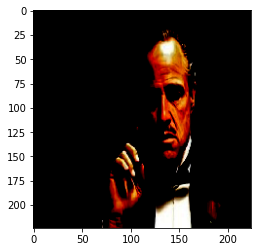

In [18]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

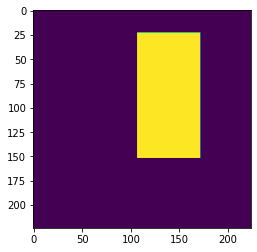

In [19]:
pyplot.imshow(masks[n])

## Create the model
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [0]:
HEIGHT_CELLS = 28
WIDTH_CELLS = 28

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

In [0]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights='imagenet')
    for layer in model.layers:
        layer.trainable = trainable

    block0 = model.get_layer("conv_pw_1_relu").output 
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block0])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

Call the model function

In [22]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_____________________________

In [0]:
def dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [0]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (5 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [0]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

Define checkpoint and early stopping

In [0]:
PATIENCE = 5

In [43]:
#checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True, save_weights_only=True, mode="min", period=1)
checkpoint = ModelCheckpoint("/content/drive/My Drive/PGPAIML/CV/Face Detection Project/modelsaved.h5", monitor="loss", verbose=1, save_best_only=True, save_weights_only=True, mode="auto", period=1)
stop = EarlyStopping(monitor="loss", patience=PATIENCE, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=PATIENCE, min_lr=1e-6, verbose=1, mode="min")

### Fit the model
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [0]:
EPOCHS = 10
BATCH_SIZE = 1
THREADS = 5

In [44]:
model.fit(x=X_train, y=masks, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, callbacks=[checkpoint,reduce_lr, stop], validation_split=0.2, workers=THREADS, use_multiprocessing=True)

Epoch 1/10
327/327 [==============================] - ETA: 0s - loss: 0.2283 - dice_coefficient: 0.8568
Epoch 00001: loss improved from inf to 0.22826, saving model to /content/drive/My Drive/PGPAIML/CV/Face Detection Project/modelsaved.h5
327/327 [==============================] - 27s 83ms/step - loss: 0.2283 - dice_coefficient: 0.8568 - val_loss: 0.8910 - val_dice_coefficient: 0.6026 - lr: 1.0000e-04
Epoch 2/10
327/327 [==============================] - ETA: 0s - loss: 0.2274 - dice_coefficient: 0.8576
Epoch 00002: loss improved from 0.22826 to 0.22743, saving model to /content/drive/My Drive/PGPAIML/CV/Face Detection Project/modelsaved.h5
327/327 [==============================] - 28s 85ms/step - loss: 0.2274 - dice_coefficient: 0.8576 - val_loss: 0.8445 - val_dice_coefficient: 0.6058 - lr: 1.0000e-04
Epoch 3/10
327/327 [==============================] - ETA: 0s - loss: 0.2277 - dice_coefficient: 0.8575
Epoch 00003: loss did not improve from 0.22743
327/327 [========================

Get the predicted mask for a sample image

In [0]:
model.load_weights("/content/drive/My Drive/PGPAIML/CV/Face Detection Project/modelsaved.h5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


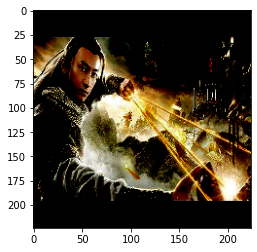

In [47]:
n = 21
sample_image = X_train[n]
final_image = sample_image
pyplot.imshow(sample_image)

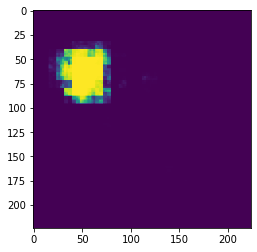

In [48]:
sample_image = np.resize(sample_image, (1, 224, 224, 3))
pred_mask = model.predict(x=sample_image)
pred_mask = np.resize(pred_mask, (224, 224))
pyplot.imshow(pred_mask)

Impose the mask on the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


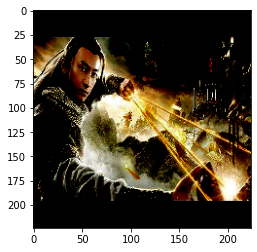

In [49]:
final_pred_mask = np.resize(pred_mask, (224,224))
final_image = np.resize(sample_image,  (224,224,3))
pyplot.imshow(final_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


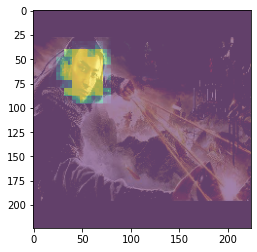

In [57]:
fig = plt.figure()
im1 = plt.imshow(final_image, alpha=0.5)
im2 = plt.imshow(final_pred_mask, alpha=0.5)
plt.show()